In [1]:
import nibabel as nib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def dataread(data_dict):
    fixed_img = data_dict['fixed_img']
    moving_img = data_dict['moving_img']
    fixed_warp = data_dict['fixed_warp']
    moving_truth = data_dict['moving_truth']
    ventricle_fixed = data_dict['ventricle_fixed']
    ventricle_moving = data_dict['ventricle_moving']
    affine = data_dict['affine']
    flow = data_dict['flow']
    cbct = data_dict['cbct']
    cbct_warp = data_dict['cbct_warp']
    return fixed_img,moving_img,fixed_warp,moving_truth,ventricle_fixed,ventricle_moving,affine,flow,cbct,cbct_warp

In [5]:
from skimage.transform import resize 
def flow_down(flow,size = [128,160,128]):
    _,x,y,z,_ = flow.shape
    fx = flow[0,:,:,:,0]
    fy = flow[0,:,:,:,1]
    fz = flow[0,:,:,:,2]
    fx = resize(fx,size,order = 3)*128/x
    fy = resize(fy,size,order = 3)*160/y
    fz = resize(fz,size,order = 3)*128/z
    f = np.stack((fx, fy, fz), axis=0)
    f = f[np.newaxis,:]
    return f



In [10]:
from layers import SpatialTransformer
import os
from tqdm import tqdm
train_path = "/mnt/blackhole-data2/RadOnc_Brain/NonRigid_Training_CBCT"
write_dir = '/home/myi16/jsr_Y/new_flow'
for i in tqdm(range(400)):
    data = np.load(train_path+f'/{i:03}.npz')
    fixed_img,moving_img,fixed_warp,moving_truth,ventricle_fixed,ventricle_moving,affine,flow,cbct,cbct_warp = dataread(data)
    flow = flow_down(flow)
    
    cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    mr = torch.from_numpy(moving_truth).unsqueeze(0).unsqueeze(0).float()
    ct = torch.from_numpy(fixed_img).unsqueeze(0).unsqueeze(0).float()
    mask = torch.from_numpy(ventricle_fixed).unsqueeze(0).unsqueeze(0).float()
    # cbct_warp  = torch.from_numpy(cbct_warp).unsqueeze(0).unsqueeze(0).float()
    # fixed_warp  = torch.from_numpy(fixed_warp).unsqueeze(0).unsqueeze(0).float()
    # moving_img  = torch.from_numpy(moving_img).unsqueeze(0).unsqueeze(0).float()
    

    original_shape = [128,160,128]
    transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
    transformer_nearest = SpatialTransformer(original_shape, mode='nearest')
    cbct_deform = transformer_linear(cbct,flow)
    ct_deform = transformer_linear(ct,flow)
    mr_deform = transformer_linear(mr,flow)
    mask_deform = transformer_nearest(mask,flow)
    # plt.style.use('dark_background')
    
    # fig, ax = plt.subplots(4,4,figsize=(12,8))
    # np.vectorize(lambda ax: ax.axis('off'))(ax)
    # ax[0][0].imshow(cbct[0,0,:,:,70].T, cmap='gray')
    # ax[0][0].set_title('Input cbct')
    # ax[1][0].imshow(cbct_deform[0,0,:,:,70].T, cmap='gray')
    # ax[1][0].set_title('Input cbct(deformed)')
    # ax[2][0].imshow(cbct_warp[0,0,:,:,70].T, cmap='gray')
    # ax[2][0].set_title('Input cbct(Runze)')
    # im = ax[3][0].imshow(cbct_warp[0,0,:,:,70].T-cbct_deform[0,0,:,:,70].numpy().T, cmap='bwr',vmin = -0.1,vmax = 0.1)
    # ax[3][0].set_title('Signed error')
    # cbar = plt.colorbar(im, ax=ax[3][0])
    # print((cbct_warp[0,0,:,:,70].T-cbct_deform[0,0,:,:,70].numpy().T).mean(),(cbct_warp[0,0,:,:,70].T-cbct_deform[0,0,:,:,70].numpy().T).std())

    # ax[0][1].imshow(ct[0,0,:,:,70].T, cmap='gray')
    # ax[0][1].set_title('Input CT')
    # ax[1][1].imshow(ct_deform[0,0,:,:,70].T, cmap='gray')
    # ax[1][1].set_title('Input CT(deformed)')
    # ax[2][1].imshow(fixed_warp[0,0,:,:,70].T, cmap='gray')
    # ax[2][1].set_title('Input CT(Runze)')
    # im2 = ax[3][1].imshow(fixed_warp[0,0,:,:,70].T-ct_deform[0,0,:,:,70].numpy().T, cmap='bwr',vmin = -0.1,vmax = 0.1)
    # ax[3][1].set_title('Signed error')
    # cbar = plt.colorbar(im2, ax=ax[3][1])
    # print((fixed_warp[0,0,:,:,70].T-ct_deform[0,0,:,:,70].numpy().T).mean(),(fixed_warp[0,0,:,:,70].T-ct_deform[0,0,:,:,70].numpy().T).std())

    # ax[0][2].imshow(mr[0,0,:,:,70].T, cmap='gray')
    # ax[0][2].set_title('Input MR')
    # ax[1][2].imshow(mr_deform[0,0,:,:,70].T, cmap='gray')
    # ax[1][2].set_title('Input MR(deformed)')
    # ax[2][2].imshow(moving_img[0,0,:,:,70].T, cmap='gray')
    # ax[2][2].set_title('Input MR(Runze)')
    # im3 = ax[3][2].imshow(moving_img[0,0,:,:,70].T-mr_deform[0,0,:,:,70].numpy().T, cmap='bwr',vmin = -0.1,vmax = 0.1)
    # ax[3][2].set_title('Signed error')
    # cbar = plt.colorbar(im3, ax=ax[3][2])
    # print((moving_img[0,0,:,:,70].T-mr_deform[0,0,:,:,70].numpy().T).mean(),(moving_img[0,0,:,:,70].T-mr_deform[0,0,:,:,70].numpy().T).std())

    # ax[0][3].imshow(ventricle_fixed[:,:,70].T)
    # ax[0][3].set_title('Malpem segmentation')
    # ax[1][3].imshow(mask_deform[0,0,:,:,70].T)
    # ax[1][3].set_title('Malpen segmentation(deformed)')
    # ax[2][3].imshow(ventricle_moving[:,:,70].T)
    # ax[2][3].set_title('Malpen segmentation(deformed)')
    # plt.show()

    np.savez(os.path.join(write_dir, f"{i:03}.npz"),
             fixed_img=fixed_img, moving_img=mr_deform.squeeze(0).squeeze(0), fixed_warp=ct_deform.squeeze(0).squeeze(0),
             moving_truth=moving_truth, ventricle_fixed=ventricle_fixed, ventricle_moving=mask_deform.squeeze(0).squeeze(0),
             affine=affine, flow=flow,
             cbct=cbct.squeeze(0).squeeze(0), cbct_warp=cbct_deform.squeeze(0).squeeze(0))




100%|██████████| 400/400 [1:04:57<00:00,  9.74s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

-6.1151572e-06 0.008801837
3.4232697e-05 0.0042774016
4.1921663e-05 0.001999052


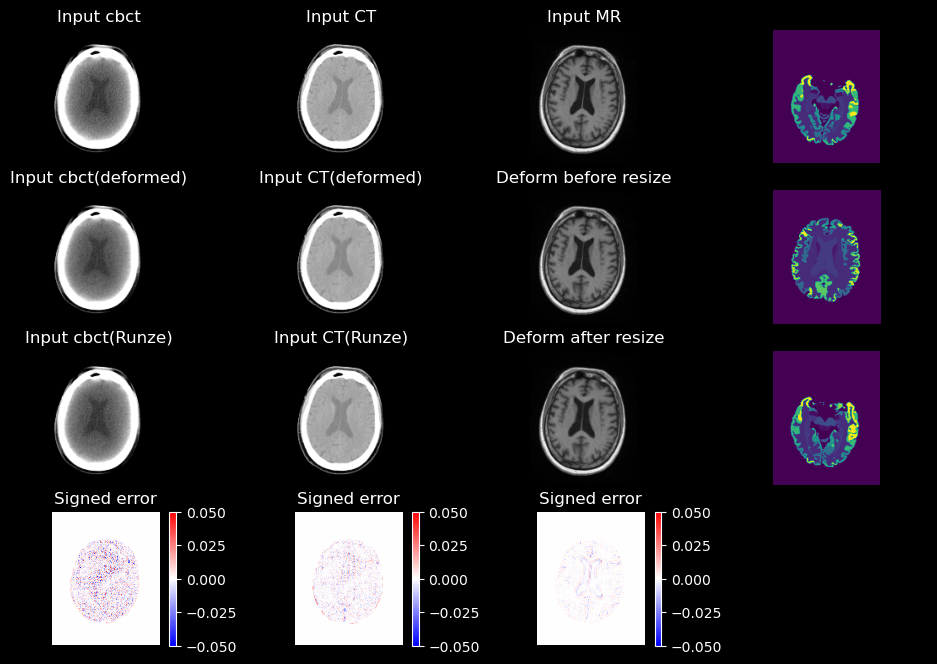

 10%|█         | 1/10 [00:29<04:23, 29.29s/it]

8.688305e-05 0.00940371
0.00018722424 0.00695671
4.2894862e-05 0.0019473052


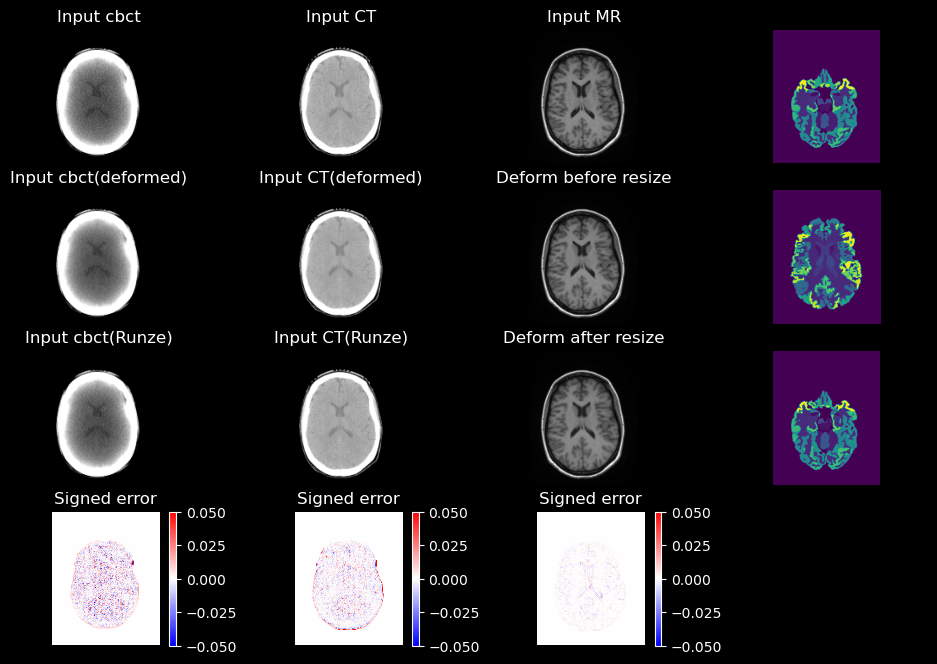

 20%|██        | 2/10 [00:57<03:50, 28.79s/it]

2.4587905e-06 0.009088503
3.0375111e-05 0.0058983047
9.220696e-06 0.001999367


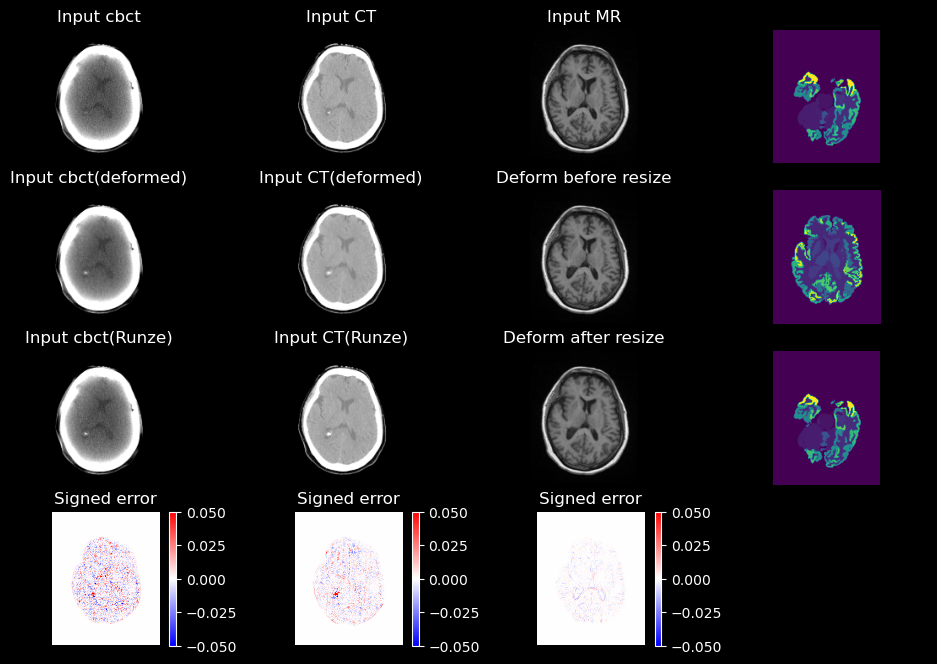

 30%|███       | 3/10 [01:26<03:20, 28.69s/it]

1.2306593e-05 0.009755789
3.5230012e-05 0.005342934
-1.4036537e-05 0.0024278355


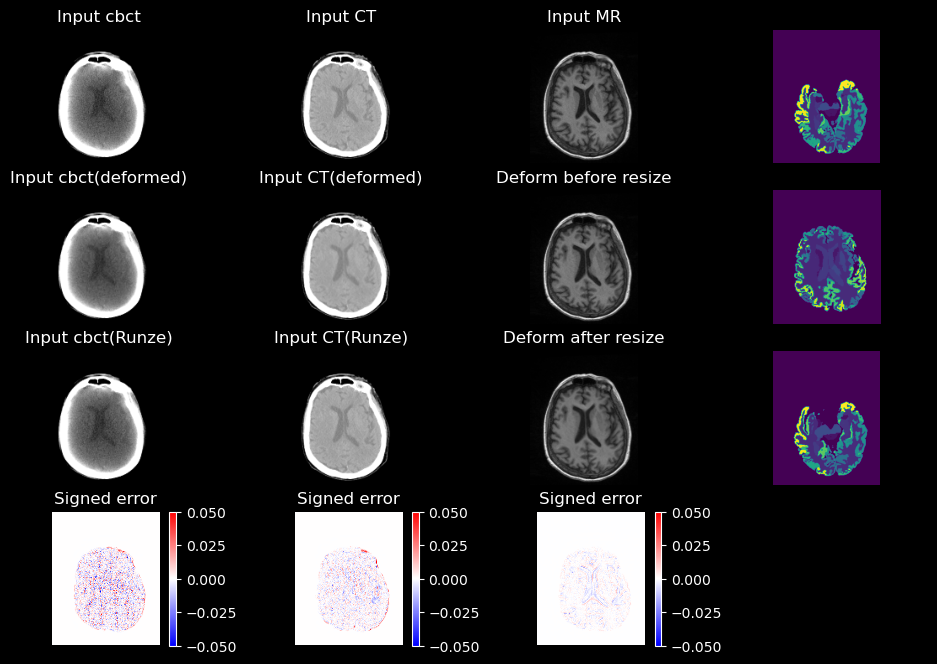

 40%|████      | 4/10 [01:54<02:50, 28.48s/it]

0.00010477167 0.008381983
7.8608675e-05 0.005920332
1.2409694e-05 0.0019012009


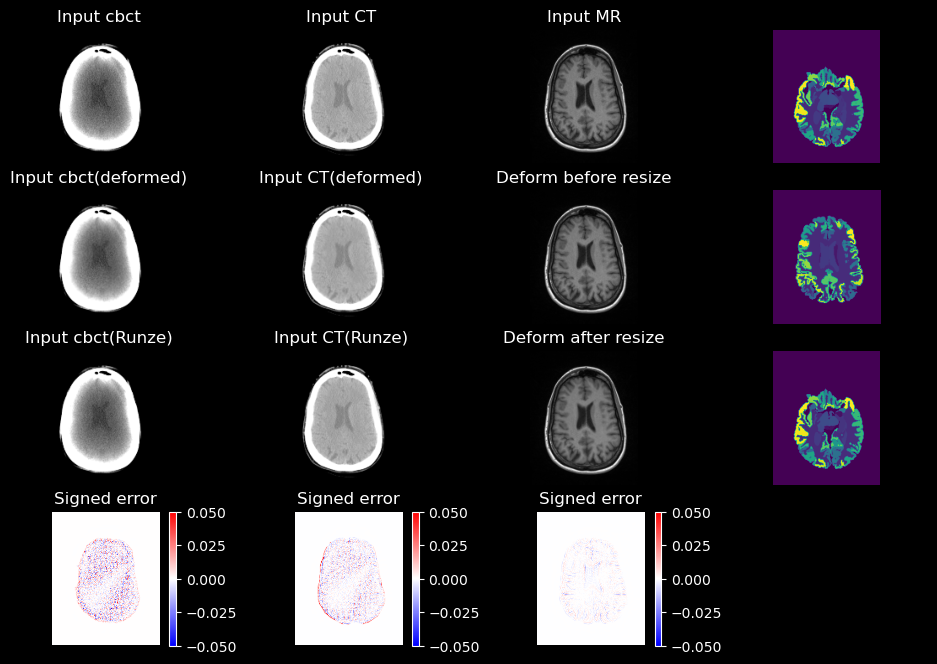

 50%|█████     | 5/10 [02:22<02:21, 28.28s/it]

6.5010296e-05 0.008670914
4.965383e-05 0.007674723
-2.5708086e-05 0.0021685346


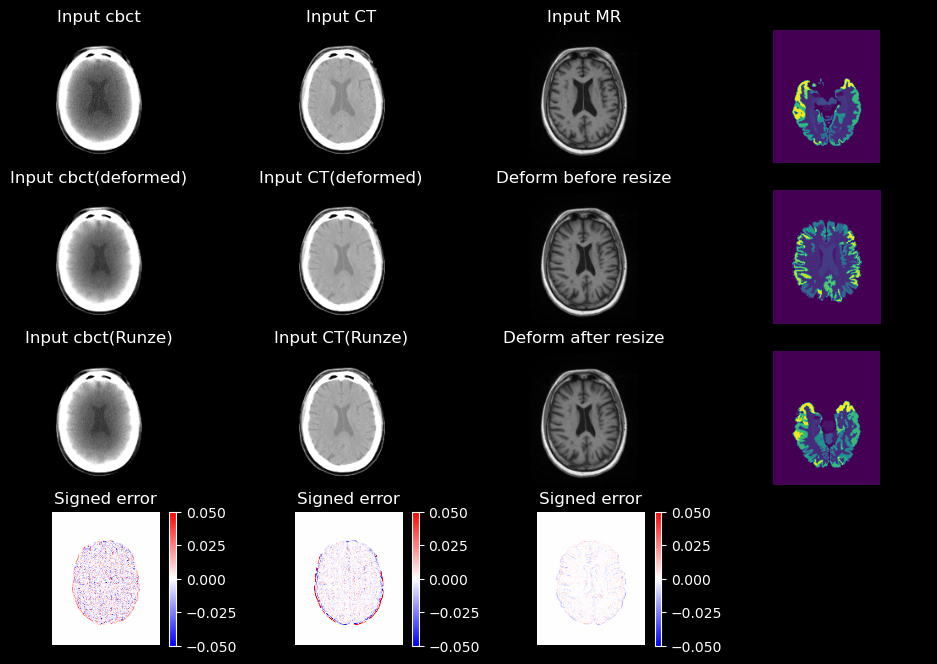

 60%|██████    | 6/10 [02:51<01:53, 28.47s/it]

7.884427e-05 0.008553007
0.00014210721 0.005915281
2.3751341e-05 0.0016409146


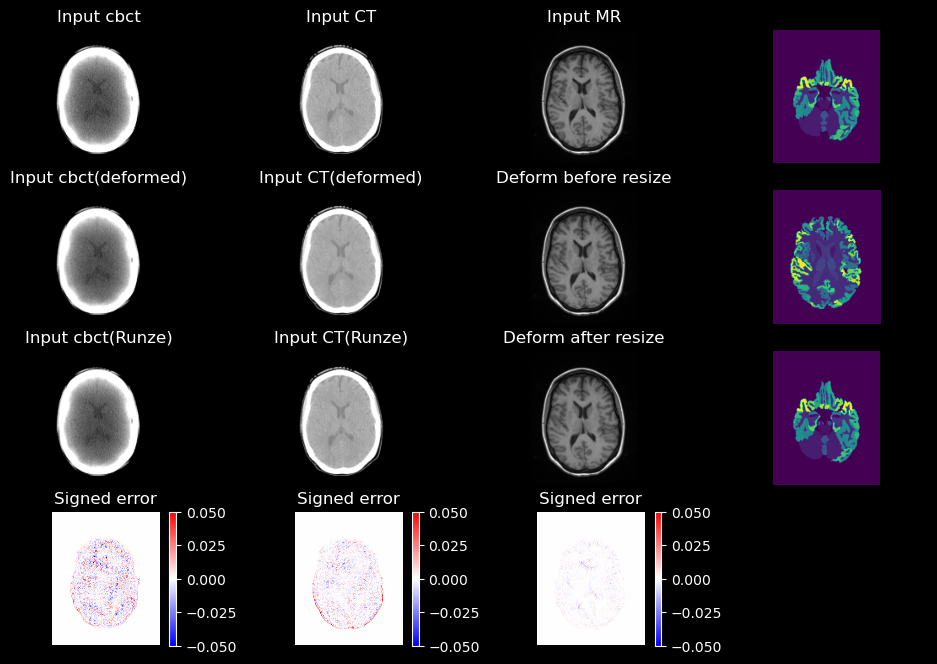

 70%|███████   | 7/10 [03:19<01:24, 28.31s/it]

2.8323859e-05 0.008653721
0.0001201165 0.006219167
1.7883798e-05 0.0020915112


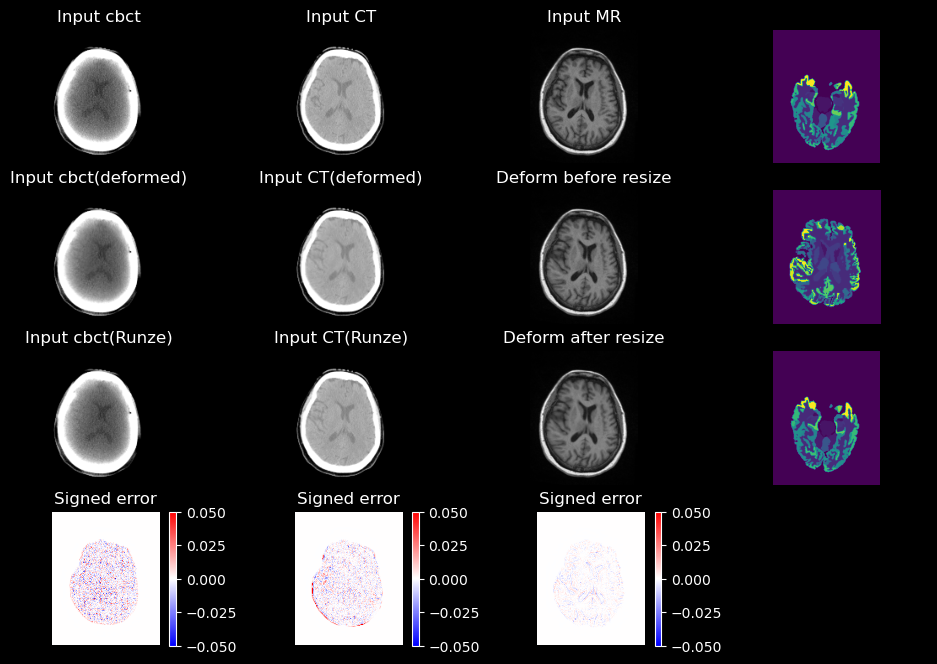

 80%|████████  | 8/10 [03:47<00:56, 28.38s/it]

2.4894747e-05 0.008504904
8.400998e-05 0.006738855
4.4054614e-06 0.0022600202


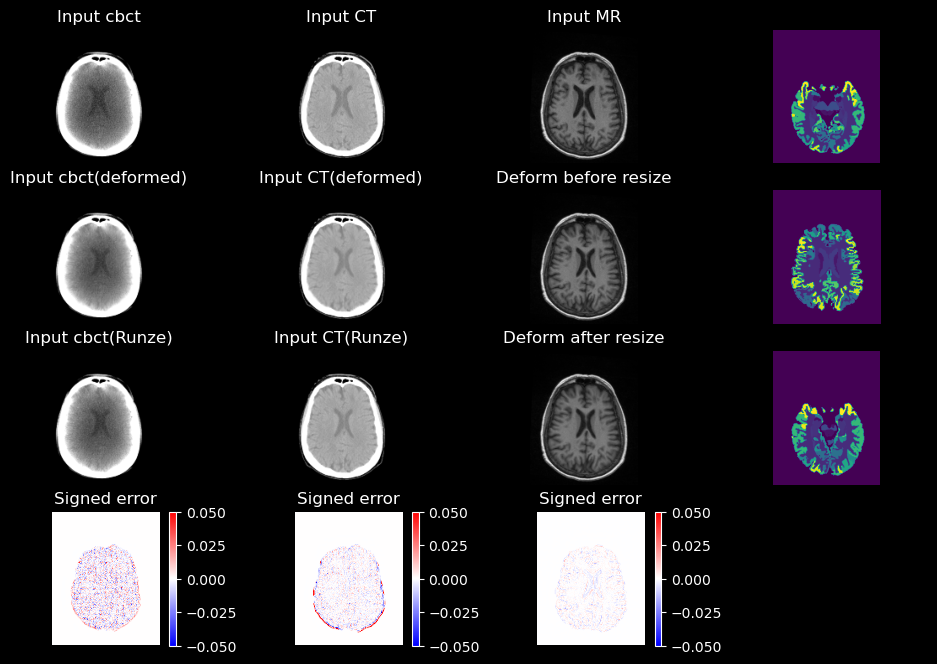

 90%|█████████ | 9/10 [04:15<00:28, 28.17s/it]

7.218247e-05 0.0096398415
3.8005037e-05 0.0063896663
5.079049e-05 0.0021661879


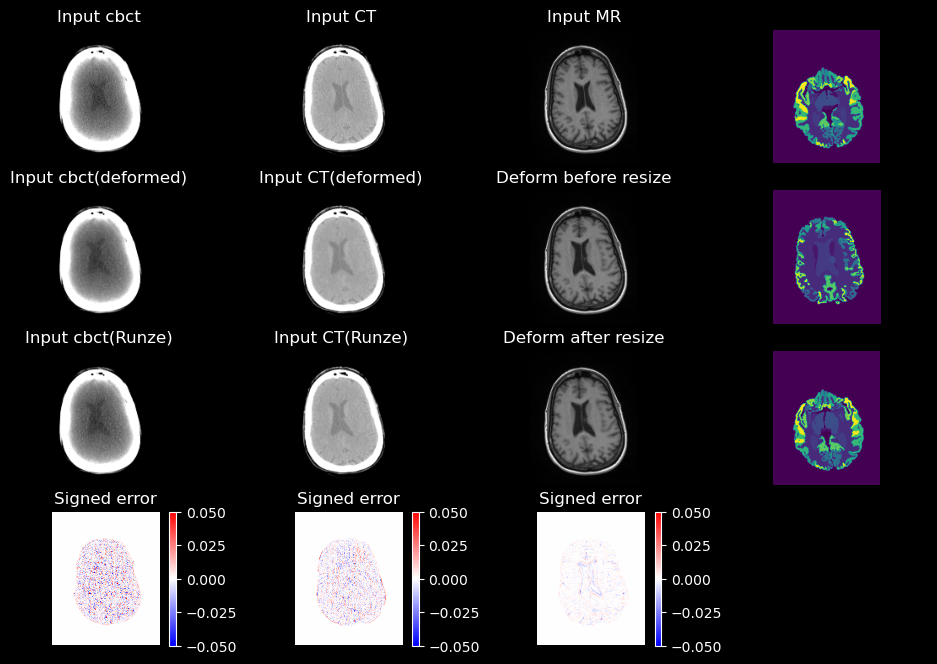

100%|██████████| 10/10 [04:43<00:00, 28.33s/it]


In [7]:
from layers import SpatialTransformer
import os
from tqdm import tqdm
from skimage.transform import resize

train_path = "/mnt/blackhole-data2/RadOnc_Brain/Validation"
write_dir = '/home/myi16/jsr_Y/md4_val'
for i in tqdm(range(1,10)):
    original_shape = [128,160,128]
    data = np.load(train_path+f'/{i:03}.npz')
    fixed_img,moving_img,fixed_warp,moving_truth,ventricle_fixed,ventricle_moving,affine,flow,cbct,cbct_warp = dataread(data)
    flow = flow_down(flow)
    # affine  =[[1, 0,  0,
    #      0],
    #    [0,  1, 0,
    #     0],
    #    [ 0,  0,  1,
    #     0],
    #    [ 0,  0,  0,
    #      1]]
    # # nib.Nifti1Image(cbct,affine=affine).to_filename('cbct_runze.nii.gz')
    # nib.Nifti1Image(moving_img,affine=affine).to_filename('mri_runze.nii.gz')
    cbct = torch.from_numpy(resize(cbct,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()
    mr = torch.from_numpy(resize(moving_truth,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()
    ct = torch.from_numpy(resize(fixed_img,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()
    mask = torch.from_numpy(resize(ventricle_fixed,original_shape,order = 0)).unsqueeze(0).unsqueeze(0).float()
    transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
    transformer_nearest = SpatialTransformer(original_shape, mode='nearest')
    cbct_deform = transformer_linear(cbct,flow)
    ct_deform = transformer_linear(ct,flow)
    mr_deform = transformer_linear(mr,flow)
    mask_deform = transformer_nearest(mask,flow)
    
    moving_img = resize(moving_img,original_shape,order = 3)
    cbct_warp = resize(cbct_warp,original_shape,order = 3)
    fixed_warp = resize(fixed_warp,original_shape,order = 3)

    plt.style.use('dark_background')
    fig, ax = plt.subplots(4,4,figsize=(12,8))
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    
    ax[0][0].imshow(cbct[0,0,:,:,70].T, cmap='gray')
    ax[0][0].set_title('Input cbct')
    ax[1][0].imshow(cbct_deform[0,0,:,:,70].T, cmap='gray')
    ax[1][0].set_title('Input cbct(deformed)')
    ax[2][0].imshow(cbct_warp[:,:,70].T, cmap='gray')
    ax[2][0].set_title('Input cbct(Runze)')
    im = ax[3][0].imshow(cbct_warp[:,:,70].T-cbct_deform[0,0,:,:,70].numpy().T, cmap='bwr',vmin = -0.05, vmax = 0.05)
    ax[3][0].set_title('Signed error')
    cbar = plt.colorbar(im, ax=ax[3][0])
    print((cbct_warp[:,:,70].T-cbct_deform[0,0,:,:,70].numpy().T).mean(),(cbct_warp[:,:,70].T-cbct_deform[0,0,:,:,70].numpy().T).std())

    ax[0][1].imshow(ct[0,0,:,:,70].T, cmap='gray')
    ax[0][1].set_title('Input CT')
    ax[1][1].imshow(ct_deform[0,0,:,:,70].T, cmap='gray')
    ax[1][1].set_title('Input CT(deformed)')
    ax[2][1].imshow(fixed_warp[:,:,70].T, cmap='gray')
    ax[2][1].set_title('Input CT(Runze)')
    im1 = ax[3][1].imshow(fixed_warp[:,:,70].T-ct_deform[0,0,:,:,70].numpy().T, cmap='bwr',vmin = -0.05, vmax = 0.05)
    ax[3][1].set_title('Signed error')
    cbar = plt.colorbar(im1, ax=ax[3][1])
    print((fixed_warp[:,:,70].T-ct_deform[0,0,:,:,70].numpy().T).mean(),(fixed_warp[:,:,70].T-ct_deform[0,0,:,:,70].numpy().T).std())

    ax[0][2].imshow(mr[0,0,:,:,70].T, cmap='gray')
    ax[0][2].set_title('Input MR')
    ax[2][2].imshow(mr_deform[0,0,:,:,70].T, cmap='gray')
    ax[2][2].set_title('Deform after resize')
    ax[1][2].imshow(moving_img[:,:,70].T, cmap='gray')
    ax[1][2].set_title('Deform before resize')
    im2 = ax[3][2].imshow(moving_img[:,:,70].T-mr_deform[0,0,:,:,70].numpy().T, cmap='bwr',vmin = -0.05, vmax = 0.05)
    ax[3][2].set_title('Signed error')
    cbar = plt.colorbar(im, ax=ax[3][2])
    print((moving_img[:,:,70].T-mr_deform[0,0,:,:,70].numpy().T).mean(),(moving_img[:,:,70].T-mr_deform[0,0,:,:,70].numpy().T).std())

    ax[0][3].imshow(ventricle_fixed[:,:,70].T)
    # ax[0][3].set_title('Malpem segmentation')
    ax[1][3].imshow(mask_deform[0,0,:,:,70].T)
    # ax[1][3].set_title('Malpen segmentation(deformed)')
    ax[2][3].imshow(ventricle_moving[:,:,70].T)
    # ax[2][3].set_title('Malpen segmentation(deformed)')
    plt.show()

    # data = {'ct_fixed':ct.squeeze(0).squeeze(0).numpy(), 'mr_moving':mr_deform, 'ct_moving':ct_deform.squeeze(0).squeeze(0).numpy(),
    #          'moving_truth':mr, 'seg_fixed':mask, 'seg_moving':mask_deform,
    #          'affine':affine, 'flow':flow, #'sources':sources,
    #          'cbct_fixed':cbct, 'cbct_warp':cbct_deform}
    # torch.save(data,os.path.join(write_dir, f"{i:03}.pt"))

    # np.savez(os.path.join(write_dir, f"{i:03}.npz"),
    #          fixed_img=fixed_img, moving_img=mr_deform.squeeze(0).squeeze(0), fixed_warp=fixed_warp,
    #          moving_truth=moving_truth, ventricle_fixed=ventricle_fixed, ventricle_moving=mask_deform.squeeze(0).squeeze(0),
    #          affine=affine, flow=flow,
    #          cbct=cbct.squeeze(0).squeeze(0), cbct_warp=cbct_deform.squeeze(0).squeeze(0))




In [11]:
from layers import SpatialTransformer
import os
from tqdm import tqdm
from skimage.transform import resize

train_path = "/mnt/blackhole-data2/RadOnc_Brain/Validation"
write_dir = '/home/myi16/jsr_Y/runze_val'
for i in tqdm(range(10)):
    original_shape = [128,160,128]
    data = np.load(train_path+f'/{i:03}.npz')
    fixed_img,moving_img,fixed_warp,moving_truth,ventricle_fixed,ventricle_moving,affine,flow,cbct,cbct_warp = dataread(data)

    cbct = torch.from_numpy(resize(cbct,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()
    mr = torch.from_numpy(resize(moving_truth,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()
    ct = torch.from_numpy(resize(fixed_img,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()
    mask = torch.from_numpy(resize(ventricle_fixed,original_shape,order = 0)).unsqueeze(0).unsqueeze(0).float()
    mask_deform = torch.from_numpy(resize(ventricle_moving,original_shape,order = 0)).unsqueeze(0).unsqueeze(0).float()

    moving_img = torch.from_numpy(resize(moving_img,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()
    cbct_warp = torch.from_numpy(resize(cbct_warp,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()
    fixed_warp = torch.from_numpy(resize(fixed_warp,original_shape,order = 3)).unsqueeze(0).unsqueeze(0).float()


    data = {'ct_fixed':ct.squeeze(0).squeeze(0).numpy(), 'mr_moving':moving_img, 'ct_moving':fixed_warp.squeeze(0).squeeze(0).numpy(),
             'moving_truth':mr, 'seg_fixed':mask, 'seg_moving':mask_deform,
             'affine':affine, 'flow':flow, #'sources':sources,
             'cbct_fixed':cbct, 'cbct_warp':cbct_warp}
    torch.save(data,os.path.join(write_dir, f"{i:03}.pt"))

    # np.savez(os.path.join(write_dir, f"{i:03}.npz"),
    #          fixed_img=fixed_img, moving_img=mr_deform.squeeze(0).squeeze(0), fixed_warp=fixed_warp,
    #          moving_truth=moving_truth, ventricle_fixed=ventricle_fixed, ventricle_moving=mask_deform.squeeze(0).squeeze(0),
    #          affine=affine, flow=flow,
    #          cbct=cbct.squeeze(0).squeeze(0), cbct_warp=cbct_deform.squeeze(0).squeeze(0))




100%|██████████| 10/10 [03:40<00:00, 22.05s/it]


In [10]:
moving_truth.shape


(270, 341, 180)

In [28]:
def var(a,b,c,d,e,f):
    m = (a+b+c+d+e+f)/6
    a -= m
    b-= m
    c -= m
    d -= m
    e -=m
    f -= m
    return (a**2+b**2+c**2+d**2+e**2+f**2)/6

In [29]:
var(1,1,1,5,6,7)

6.583333333333333

In [30]:
var(1,3,3,3,5,6)

2.5833333333333335

In [31]:
var(3,3,3,3,4,4)

0.2222222222222222

In [32]:
var(0,2,4,4,4,6)

3.555555555555556

In [33]:
var(1,2,3,4,5,6)

2.9166666666666665